So the motivation for this was, to be entirely honest, kind of selfish. I'm buying a house and I want to see how much my house *could* increase by in 'N' years. Basically, a kind of experiment. It is also handy for me to practice time-series analysis, bit of data science stuff, and some ML practice.

The project is broken down into a few parts:
1. the web-scraping, to gather data from the [RightMove.co.uk](https://www.rightmove.co.uk) website. For historical data, and then use this to try and predict how the houses will increase.
2. the analysis of the data, see if there any trends I can see from this analysis as is.
3. the forecasting, can I do some basic forecasting with the data alone, or can I set up an ML model to predict it for me.

# 1. Importing and Pre-Processing
## 1.1 Imports and Load Data

In [1]:
random_code = 42  # Random code to use and replicate results for each run.

# File imports 
import os

# Data Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Geography imports
import plotly.express as px
from IPython.display import IFrame
        
# Personal Import
from Dataset_Snapshot import RightMoveScraper

Run the next function as needed if you need a new CSV to work with. This will generate a CSV for every run of this code, this is not ideal. Plus also as a basic tool, a separate python file will suffice.

In [2]:
"""# Create an instance of the scraper
scraper = RightMoveScraper(num_pages=10)  # Adjust the number of pages as needed
scraper.run()"""

'# Create an instance of the scraper\nscraper = RightMoveScraper(num_pages=10)  # Adjust the number of pages as needed\nscraper.run()'

In [3]:
data_file = 'rightmove_housing_data_20250330_233719.csv'
df = pd.read_csv(data_file)

## 1.2 Data Clean Up
Tidy up the data now as it's not really in a state to use just yet.

In [4]:
print(df.dtypes)  # Look at the types of each column

address           object
propertyType      object
bedrooms         float64
bathrooms        float64
latitude         float64
longitude        float64
display_price     object
date_sold         object
dtype: object


In [5]:
# Display Price Changes - change from 'str' to 'float'
df['display_price'] = df['display_price'].replace('[^0-9.]', '', regex=True).astype(float) 
# Date Sold changes - change from DD-MM-YYYY 'str' to YYYYMMDD 'int'
df['date_sold'] = pd.to_datetime(df['date_sold'], errors='coerce')
df['date_sold'] = df['date_sold'].dt.strftime('%Y%m%d').astype(int)
print(df.dtypes)  # Look 

address           object
propertyType      object
bedrooms         float64
bathrooms        float64
latitude         float64
longitude        float64
display_price    float64
date_sold          int32
dtype: object


In [6]:
df.head()

,address,propertyType,bedrooms,bathrooms,latitude,longitude,display_price,date_sold
0,"9, Stallcourt Avenue, Cardiff CF23 5AL",TERRACED,3.0,2.0,51.49517,-3.15421,437000.0,20250110
1,"9, Stallcourt Avenue, Cardiff CF23 5AL",TERRACED,3.0,2.0,51.49517,-3.15421,330000.0,20190418
2,"87, Clifton Street, Cardiff CF24 1LT",TERRACED,3.0,1.0,51.48374,-3.15580,240000.0,20250110
3,"87, Clifton Street, Cardiff CF24 1LT",TERRACED,3.0,1.0,51.48374,-3.15580,207000.0,20221028
4,"87, Clifton Street, Cardiff CF24 1LT",TERRACED,3.0,1.0,51.48374,-3.15580,151000.0,20150723


## 1.3 Basic Analysis

In [ ]:

color_scale = [(0, 'yellow'), (1,'red')]
# Display the data on the map
map_fig = px.scatter_mapbox(df, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="address", 
                        hover_data=["address", "display_price", 'date_sold'],
                        color="display_price",
                        color_continuous_scale=color_scale,
                        size="display_price",
                        zoom=13, 
                        height=600,
                        width=1200)

map_fig.update_layout(mapbox_style="open-street-map")
map_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
map_fig.show()

map_fig.write_image("img//mapped_dataset.jpg")

Displaying a copy of the above two cells, as it doesn't show the interactive plotly fig in git.
![alt text](./img//mapped_dataset.jpg "Title")

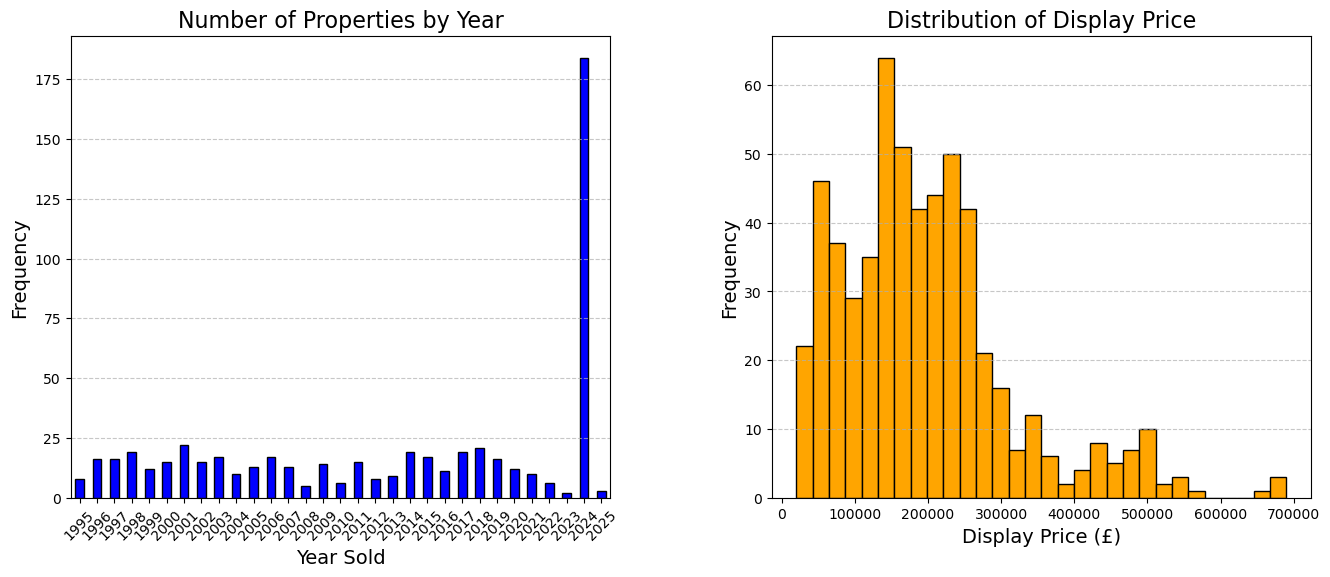

In [9]:
# Extract the year from the 'date_sold' column
df['year_sold'] = pd.to_datetime(df['date_sold'], format='%Y%m%d', errors='coerce').dt.year

fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'wspace': 0.3})

# First subplot: Number of properties by year
df['year_sold'].value_counts().sort_index().plot(kind='bar', edgecolor='black', ax=axes[0], color='blue')
axes[0].set_title('Number of Properties by Year', fontsize=16)
axes[0].set_xlabel('Year Sold', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Second subplot: Histogram of display_price
axes[1].hist(df['display_price'], bins=30, color='orange', edgecolor='black')
axes[1].set_title('Distribution of Display Price', fontsize=16)
axes[1].set_xlabel('Display Price (£)', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

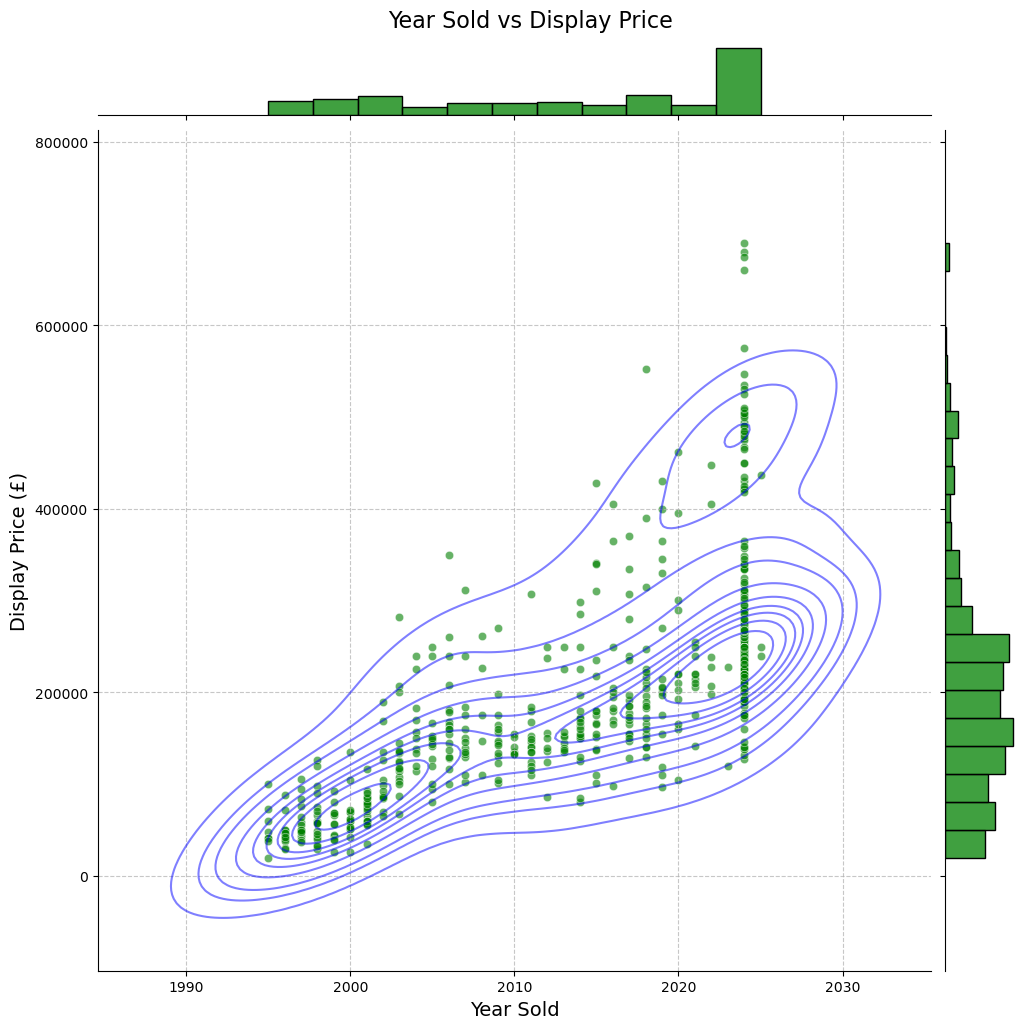

In [10]:
sns.jointplot(data=df,x='year_sold',y='display_price',kind='scatter',alpha=0.6,color='green',height=10, ratio=10) # Generate Scatter and hist
sns.kdeplot(data=df,x='year_sold',y='display_price',levels=10,color='blue',alpha=0.5,)  # KDE plot to generate contour map 

plt.suptitle('Year Sold vs Display Price', y=1.02, fontsize=16)
plt.xlabel('Year Sold', fontsize=14)
plt.ylabel('Display Price (£)', fontsize=14)

# Show the plot
plt.grid(linestyle='--', alpha=0.7)
plt.show()

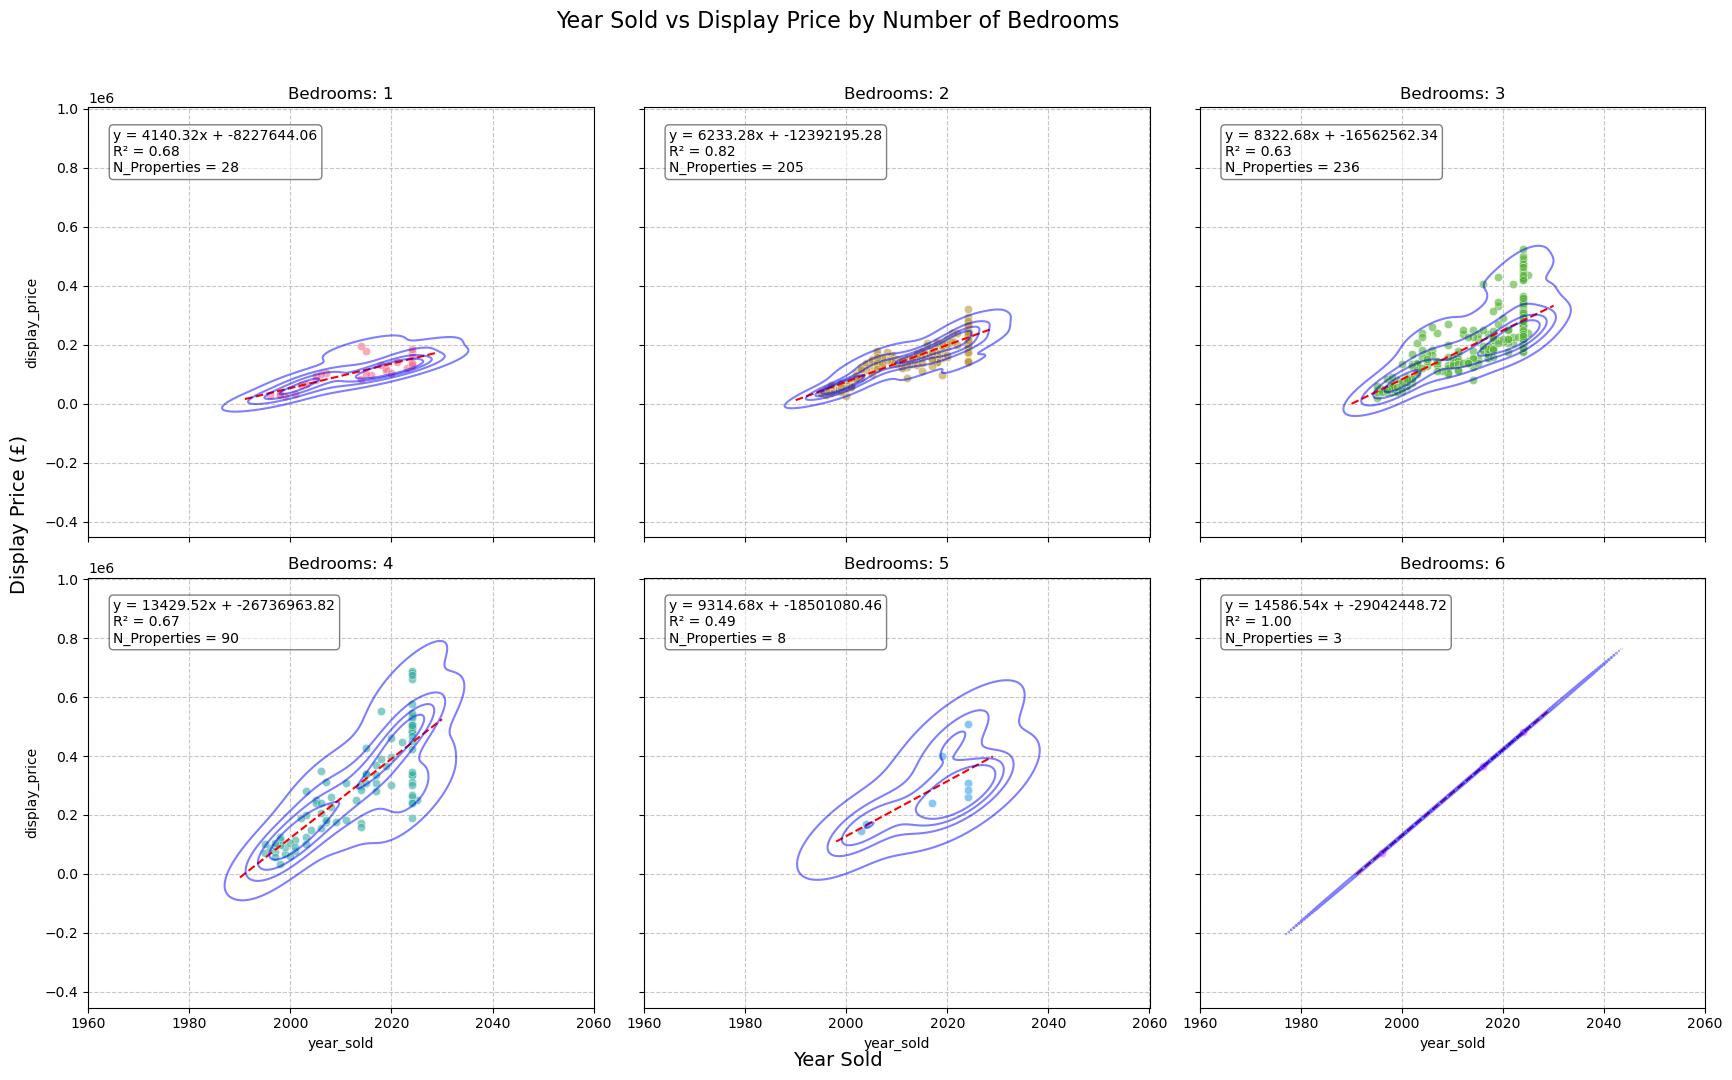

{1: {'m': array([4140.31697]), 'c': -8227644.064117551, 'r2': 0.6758838099252615, 'N': 28}, 2: {'m': array([6233.27889994]), 'c': -12392195.28039379, 'r2': 0.8217105756030633, 'N': 205}, 3: {'m': array([8322.67852082]), 'c': -16562562.344368327, 'r2': 0.6268213632262941, 'N': 236}, 4: {'m': array([13429.51925073]), 'c': -26736963.822666798, 'r2': 0.671956503006311, 'N': 90}, 5: {'m': array([9314.67523831]), 'c': -18501080.458878297, 'r2': 0.49042314792622743, 'N': 8}, 6: {'m': array([14586.53846154]), 'c': -29042448.717948724, 'r2': 0.999982473897695, 'N': 3}}


In [11]:
# Get unique values for the number of bedrooms
unique_bedrooms = np.sort(df['bedrooms'].dropna().unique())

# Define a list of colors for the subplots
colors = sns.color_palette("husl", len(unique_bedrooms))

fig, axes = plt.subplots(nrows=int(np.ceil(len(unique_bedrooms) / 3)), ncols=3, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

lin_reg = {}
# Loop through each unique number of bedrooms and plot
for i, bedrooms in enumerate(unique_bedrooms):
    ax = axes[i]
    subset = df[df['bedrooms'] == bedrooms]  # Filter data for the current number of bedrooms
    
    # Scatter plot
    sns.scatterplot(data=subset, x='year_sold', y='display_price', alpha=0.6, ax=ax, color=colors[i])
    
    # Fit linear regression
    if len(subset) > 1:  # Ensure there is enough data to fit a regression
        X = subset['year_sold'].values.reshape(-1, 1)
        y_vals = subset['display_price'].values
        reg = LinearRegression().fit(X, y_vals)
        # Extend regression line
        x_range = np.linspace(X.min() - 5, X.max() + 5, 100).reshape(-1, 1)
        y_range = reg.predict(x_range)
        ax.plot(x_range, y_range, color='red', linestyle='--', label='Regression Line')
        
        # Calculate R²
        r2 = reg.score(X, y_vals)
        
        # Add regression equation, R², and number of data points to the plot
        ax.text(0.05, 0.95, f"y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}\nR² = {r2:.2f}\nN_Properties = {len(subset)}",
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round", alpha=0.5, facecolor="white"))
        
        # Dictionary output
        lin_reg[int(bedrooms)] = {'m': reg.coef_, 'c': reg.intercept_, 'r2': r2, 'N':len(subset)}

    else:
        # Add number of data points if regression is not performed
        ax.text(0.05, 0.95, f"N = {len(subset)}",
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round", alpha=0.5, facecolor="white"))

    # KDE plot
    sns.kdeplot(data=subset, x='year_sold', y='display_price', levels=5, color='blue', alpha=0.5, ax=ax)
    
    ax.set_title(f"Bedrooms: {int(bedrooms)}")
    ax.grid(linestyle='--', alpha=0.7)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Year Sold vs Display Price by Number of Bedrooms", y=0.92, fontsize=16)
fig.text(0.5, 0.04, "Year Sold", ha="center", fontsize=14)
fig.text(0.04, 0.5, "Display Price (£)", va="center", rotation="vertical", fontsize=14)

# Show the plot
plt.tight_layout(rect=[0.04, 0.04, 1, 0.9])
plt.show()

print(lin_reg)

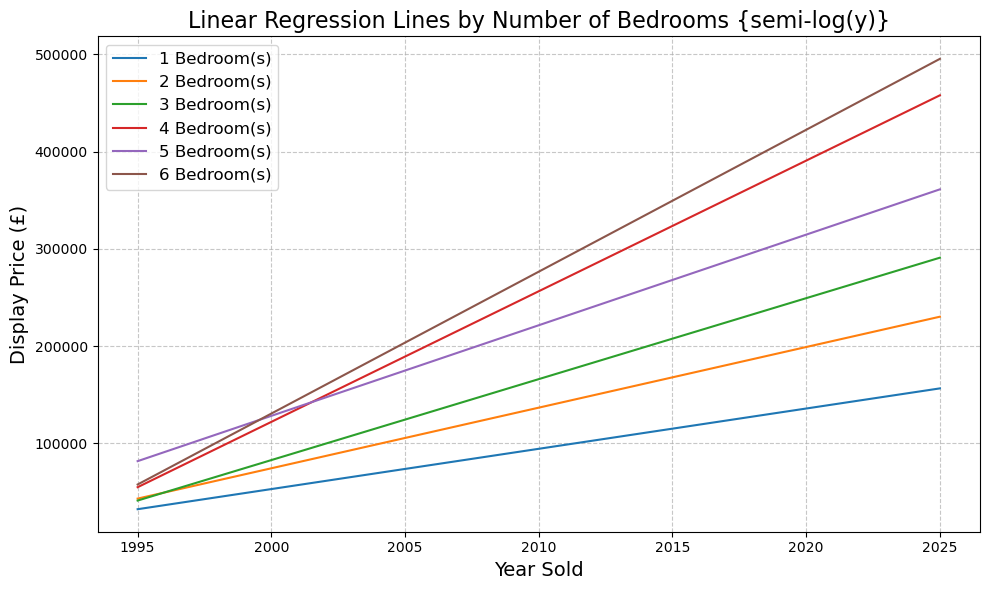

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
x_range = np.linspace(df['year_sold'].min(), df['year_sold'].max(), 100)

# Loop through each bedroom and plot its regression line
for bedrooms in lin_reg.keys():
    m = lin_reg[bedrooms]['m']  # Slope
    c = lin_reg[bedrooms]['c']  # Intercept
    y_range = m * x_range + c  # Calculate y values for the regression line
    ax.plot(x_range, y_range, label=f"{int(bedrooms)} Bedroom(s)")  # Plot the line

ax.set_title('Linear Regression Lines by Number of Bedrooms {semi-log(y)}', fontsize=16)
ax.set_xlabel('Year Sold', fontsize=14)
ax.set_ylabel('Display Price (£)', fontsize=14)
ax.legend(loc='best', fontsize=12)
ax.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()